In [13]:
# import json 
import pandas as pd 
import re
import numpy as np
# from mtgsdk import Card
# import numpy as np

from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import plotly.express as px
import hvplot.pandas
%matplotlib inline

In [14]:
UNWANTED_COLUMNS = ['index', 'artist', 'availability', 'borderColor',
       'colors', 'convertedManaCost', 'edhrecRank', 'finishes', 'flavorText',
       'foreignData', 'frameVersion', 'hasFoil', 'hasNonFoil', 'identifiers',
       'isPromo', 'isReprint', 'isStarter', 'keywords', 'language', 'layout',
       'legalities','number',
       'printings', 'promoTypes', 'purchaseUrls', 'rarity', 'rulings',
       'securityStamp', 'setCode', 'subtypes', 'supertypes', 'text','uuid', 'boosterTypes', 'originalText',
       'originalType', 'signature', 'originalReleaseDate', 'variations',
       'isOnlineOnly', 'isReserved', 'frameEffects', 'faceConvertedManaCost',
       'faceManaValue', 'faceName', 'leadershipSkills', 'otherFaceIds', 'side',
       'isOversized', 'reverseRelated', 'duelDeck', 'isTextless',
       'relatedCards', 'watermark', 'loyalty', 'isAlternative', 'isFunny',
       'isFullArt', 'isTimeshifted', 'rebalancedPrintings', 'asciiName',
       'isRebalanced', 'originalPrintings', 'colorIndicator', 'hand', 'life',
       'isStorySpotlight', 'flavorName', 'attractionLights',
       'hasContentWarning', 'hasAlternativeDeckLimit', 'faceFlavorName',
       'cardParts']
COLOR_COLUMNS = ["colorIdentity","manaCost", "types", "power", "toughness"]
FILE_NAME = "second_transposed.feather"
LETTERS = ['B','C','G','H','P','R','S','U','W','X','Y','Z']
TYPES = ["Land", "Creature", "Enchantments", "Artifact", "Instant","Sorceries", "Token"]

In [15]:
mtg_df = pd.read_feather(FILE_NAME).drop_duplicates("name", keep="first").drop(columns=UNWANTED_COLUMNS)
mtg_df

,colorIdentity,manaCost,manaValue,name,power,toughness,type,types
0,[U],{5}{U}{U},7.0,Sphinx of the Final Word,5,5,Creature — Sphinx,[Creature]
1,[R],{1}{R}{R},3.0,Goblin King,2,2,Creature — Goblin,[Creature]
2,[G],{G},1.0,Caravan Vigil,None,None,Sorcery,[Sorcery]
3,"[G, R]",{3}{R}{G},5.0,Deadshot Minotaur,3,4,Creature — Minotaur,[Creature]
4,[W],{2}{W},3.0,Rule of Law,None,None,Enchantment,[Enchantment]
...,...,...,...,...,...,...,...,...
77661,[B],{4}{B},5.0,Plague Dogs,3,3,Creature — Phyrexian Zombie Dog,[Creature]
77674,[R],{1}{R}{R},3.0,Traitorous Blood,None,None,Sorcery,[Sorcery]
77705,[],{7},7.0,Aether Searcher,6,4,Artifact Creature — Construct,"[Artifact, Creature]"
77717,[],{3},3.0,Network Terminal,None,None,Artifact,[Artifact]


In [16]:
mtg_df.replace(to_replace=[None], value=-1, inplace=True)
mtg_df

,colorIdentity,manaCost,manaValue,name,power,toughness,type,types
0,[U],{5}{U}{U},7.0,Sphinx of the Final Word,5,5,Creature — Sphinx,[Creature]
1,[R],{1}{R}{R},3.0,Goblin King,2,2,Creature — Goblin,[Creature]
2,[G],{G},1.0,Caravan Vigil,-1,-1,Sorcery,[Sorcery]
3,"[G, R]",{3}{R}{G},5.0,Deadshot Minotaur,3,4,Creature — Minotaur,[Creature]
4,[W],{2}{W},3.0,Rule of Law,-1,-1,Enchantment,[Enchantment]
...,...,...,...,...,...,...,...,...
77661,[B],{4}{B},5.0,Plague Dogs,3,3,Creature — Phyrexian Zombie Dog,[Creature]
77674,[R],{1}{R}{R},3.0,Traitorous Blood,-1,-1,Sorcery,[Sorcery]
77705,[],{7},7.0,Aether Searcher,6,4,Artifact Creature — Construct,"[Artifact, Creature]"
77717,[],{3},3.0,Network Terminal,-1,-1,Artifact,[Artifact]


In [97]:
types_df=mtg_df[["manaValue","power","toughness", "types"]]
types_df["power"] = types_df["power"].replace("*", -1)
types_df["toughness"] = types_df["toughness"].replace("*", -1)
types_df["power"].unique()

/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array(['5', '2', -1, '3', '1', '4', '0', '7', '6', '10', '8', '9', '∞',
       '11', '13', '12', '.5', '1.5', '+4', '2+*', '1+*', '+1', '15',
       '2.5', '16', '+3', '-1', '20', '+0', '+2', '3.5', '*²', '?'],
      dtype=object)

In [98]:
symbols = ['∞','*', '+4', '2+*', '+1', '+3', '+0', '*²','?', '1+*', "*+1"]

types_df = types_df[types_df.power.isin(symbols)==False]
types_df = types_df[types_df.toughness.isin(symbols)==False]
types_df.fillna(value =-1, inplace=True)
types_df

,manaValue,power,toughness,types
0,7.0,5,5,[Creature]
1,3.0,2,2,[Creature]
2,1.0,-1,-1,[Sorcery]
3,5.0,3,4,[Creature]
4,3.0,-1,-1,[Enchantment]
...,...,...,...,...
77661,5.0,3,3,[Creature]
77674,3.0,-1,-1,[Sorcery]
77705,7.0,6,4,"[Artifact, Creature]"
77717,3.0,-1,-1,[Artifact]


In [125]:
# # array = types_df["types"][5]
# def look_for_creature(row):
#     for i in range(len(row)):
#         if row[i] == None: 
#             return None
#         else: 
#             list_creatures={k: raw[i].count(k) for k in TYPES}
#             return pd.Series(list_creatures)
# for row in types_df["types"]: 
#     look_for_creature(row)


#     for entry in types_df["types"]:
#         array = entry
#         for j in array:
#             list_creatures = {k: j.count(k) for k in TYPES}
# return pd.Series(list_creatures)

TYPES = ["Land", "Creature", "Enchantments", "Artifact", "Instant","Sorceries", "Token"]
        
Land =[]
Creature=[]
Enchantments=[]
Artifact=[]
Instant=[]
Sorceries=[]
Token=[]

for array in types_df["types"]: 
    # tickers
    land=0
    creatures=0
    enchantment=0
    artifact=0
    instants=0
    sorceries=0
    token=0
    
    for item in array:
        if item=="Land": 
            land+=1
        elif item=="Creature": 
            creatures+=1
        elif item=="Enchantment": 
            enchantment+=1
        elif item=="Artifact": 
            artifact+=1
        elif item=="Instant": 
            instants+=1
        elif item=="Sorceries": 
            sorceries+=1
        elif item=="Token": 
            token+=1
    
        Land.append(land)
        Creature.append(creatures)
        Enchantments.append(enchantment)
        Artifact.append(artifact)
        Instant.append(instants)
        Sorceries.append(sorceries)
        Token.append(token)
dictionary = {"Creature": Creature, "Enchantments":Enchantments, "Artifact": Artifact, 
             "Instant": Instant, "Sorceries": Sorceries, "Token":Token}        
types_df_two=pd.DataFrame(dictionary)
types_df_two = types_df_two.assign(manaValue = types_df["manaValue"])
types_df_two = types_df_two.assign(power = types_df["power"])
types_df_two["manaValue"].fillna(value=-1, inplace=True)
types_df_two["power"].fillna(value=-1,inplace=True)
types_df_two    
        


,Creature,Enchantments,Artifact,Instant,Sorceries,Token,manaValue,power
0,1,0,0,0,0,0,7.0,5
1,1,0,0,0,0,0,3.0,2
2,0,0,0,0,0,0,1.0,-1
3,1,0,0,0,0,0,5.0,3
4,0,1,0,0,0,0,3.0,-1
...,...,...,...,...,...,...,...,...
28531,0,0,0,0,0,0,3.0,-1
28532,0,0,1,0,0,0,-1.0,2
28533,1,0,1,0,0,0,5.0,-1
28534,0,0,1,0,0,0,-1.0,-1


In [126]:
# [look_for_creature(value) for value in types_df["types"].values.tolist()]



In [42]:
# parsed_series=types_df["types"].apply(look_for_creature)
# types_copy_df = pd.DataFrame(parsed_series)
# types_copy_df

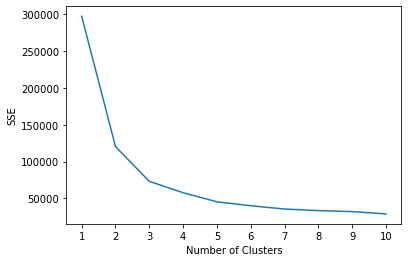

In [127]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(types_df_two)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [116]:
kmeans6 = KMeans(n_clusters=3)

x =types_df_two.iloc[:, [0,1,2,3,4,5,6]].values
y_kmeans6=kmeans6.fit_predict(x)
print(y_kmeans6)


[0 2 2 ... 0 1 1]


In [117]:
kmeans6.cluster_centers_

array([[ 0.49747269,  0.10924507,  0.13109408,  0.10272297,  0.        ,
         0.01858797,  5.01271808],
       [ 0.48595698,  0.11535827,  0.12494862,  0.10700096,  0.        ,
         0.02322236, -0.93708042],
       [ 0.49096733,  0.10570147,  0.1331198 ,  0.10608584,  0.        ,
         0.02447149,  2.24612428]])

In [118]:
from sklearn.decomposition import PCA 
pca = PCA(n_components = 3)
pca.fit(x)
pca_df=pca.transform(x)

In [119]:
km = KMeans(n_clusters=3)
km.fit(x)

KMeans(n_clusters=3)

In [120]:
pca_df

array([[ 5.78850647, -0.53527627, -0.06667563],
       [ 1.78851816, -0.54194107, -0.06025904],
       [-0.21298823,  0.38990628, -0.03737172],
       ...,
       [ 3.78965186, -0.40046454,  0.82998167],
       [-2.21184284,  0.52471801,  0.85928558],
       [-2.21147016, -0.54860588, -0.05384245]])

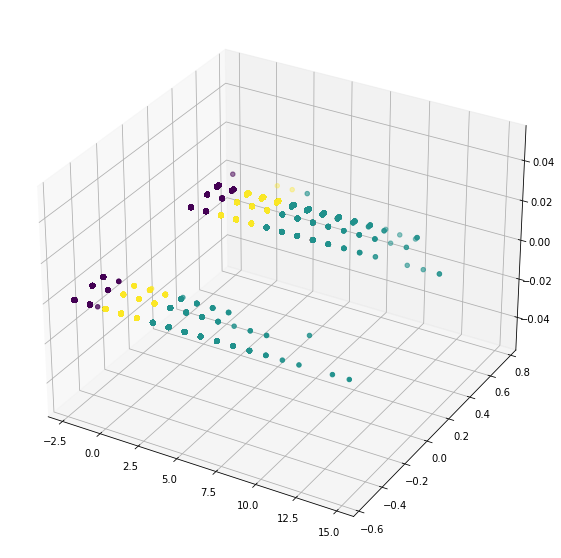

In [121]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection="3d")
ax.scatter(pca_df[:,0], pca_df[:,1],c=km.labels_)